## 概述

下面通过一个实际样例，带领大家体验MindSpore基础的功能。

本例子会实现一个简单的图片分类的功能，整体流程如下：

1. 处理需要的数据集，这里使用了MNIST数据集。
2. 定义一个网络，这里我们使用LeNet网络。
3. 自定义回调函数收集模型的损失值和精度值。
4. 定义损失函数和优化器。
5. 加载数据集并进行训练，训练完成后，查看结果及保存模型文件。
6. 加载保存的模型，进行推理。
7. 验证模型，加载测试数据集和训练后的模型，验证结果精度。

这是简单、基础的应用流程，其他高级、复杂的应用可以基于这个基本流程进行扩展。

## 准备环节

在动手进行实践之前，确保，你已经正确安装了MindSpore。如果没有，可以通过[MindSpore安装页面](https://www.mindspore.cn/install)将MindSpore安装在你的电脑当中。  

### 下载数据集

示例中用到的`MNIST`数据集是由10类$28*28$的灰度图片组成，训练数据集包含60000张图片，测试数据集包含10000张图片。

> MNIST数据集下载页面：<http://yann.lecun.com/exdb/mnist/>。页面提供4个数据集下载链接，其中前2个文件是训练数据需要，后2个文件是测试结果需要。示例中从华为云存储上下载MNIST数据集副本。

In [16]:
# Pre 
!chcp 65001

Active code page: 65001


In [17]:
!mkdir -p ./datasets/MNIST_Data/train ./datasets/MNIST_Data/test
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte 
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


下载完之后，使用tree命令查看目录结构

In [3]:
!tree ./datasets/MNIST_Data

Folder PATH listing for volume Windows-SSD
Volume serial number is 000000F5 2887:F966
C:\USERS\LIUYUZHE\DESKTOP\AI-2023\LAB2\SRC\DATASETS\MNIST_DATA
Invalid path - \USERS\LIUYUZHE\DESKTOP\AI-2023\LAB2\SRC\DATASETS\MNIST_DATA
No subfolders exist 



### 导入Python库&模块

在使用前，需要导入需要的Python库。目前使用到`os`库，为方便理解，其他需要的库，我们在具体使用到时再说明。
详细的MindSpore的模块说明，可以在[MindSpore API页面](https://www.mindspore.cn/doc/api_python/zh-CN/r1.2/index.html)中搜索查询。

In [92]:
import os

### 配置运行信息

在正式编写代码前，需要了解MindSpore运行所需要的硬件、后端等基本信息。

可以通过`context.set_context`来配置运行需要的信息，譬如运行模式、后端信息、硬件等信息。

导入`context`模块，配置运行需要的信息。

In [93]:
# conda install mindspore=2.0.0a0 -c mindspore -c conda-forge
from mindspore import context

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

在样例中我们配置样例运行使用图模式。根据实际情况配置硬件信息，譬如代码运行在Ascend AI处理器上，则`--device_target`选择`Ascend`，代码运行在CPU、GPU同理。详细参数说明，请参见`context.set_context`接口说明。

## 数据处理
数据集对于训练非常重要，好的数据集可以有效提高训练精度和效率，在加载数据集前，通常会对数据集进行一些处理。

由于后面会采用LeNet这样的卷积神经网络对数据集进行训练，而采用在训练数据时，对数据格式是有所要求的，所以接下来需要先查看数据集内的数据是什么样的，这样才能构造一个针对性的数据转换函数，将数据集数据转换成符合训练要求的数据形式。

执行如下代码查看原始数据集数据。

对于经典的MNIST等数据集，各大深度学习框架都集成了下载、预处理等操作，开发过程中只需要按照文档调用对应的api即可。

The type of mnist_ds: <class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>
Number of pictures contained in the mnist_ds： 60000
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 0
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  67 118 173 255 254 254 243  54   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  27 123 

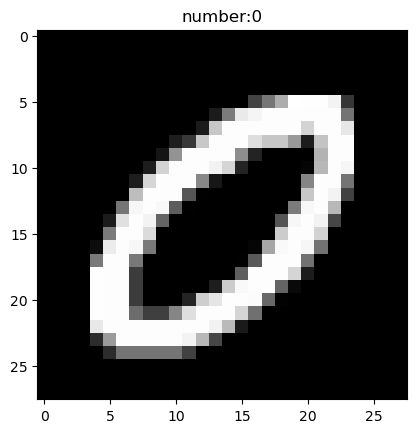

In [94]:
import matplotlib.pyplot as plt
import matplotlib    # conda install -c conda-forge matplotlib
import numpy as np
import mindspore.dataset as ds

train_data_path = "./datasets/MNIST_Data/train"
test_data_path = "./datasets/MNIST_Data/test"
mnist_ds = ds.MnistDataset(train_data_path)
print('The type of mnist_ds:', type(mnist_ds))
print("Number of pictures contained in the mnist_ds：", mnist_ds.get_dataset_size())

dic_ds = mnist_ds.create_dict_iterator()
item = next(dic_ds)  # 取出一个样本
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("The item of mnist_ds:", item.keys())
print("Tensor of image in item:", img.shape) 
print("The label of item:", label)

img = np.squeeze(img)  # 从矩阵shape中，去掉维度为1的
np.set_printoptions(linewidth=400)
print(img)

plt.imshow(img,cmap="gray")  # 默认是彩色输出
plt.title("number:%s"% item["label"].asnumpy())
plt.show()

从上面的运行情况我们可以看到，训练数据集`train-images-idx3-ubyte`和`train-labels-idx1-ubyte`对应的是6万张图片和6万个数字标签，载入数据后经过`create_dict_iterator`转换字典型的数据集，取其中的一个数据查看，这是一个key为`image`和`label`的字典，其中的`image`的张量(高度28，宽度28，通道1)和`label`为对应图片的数字。

### 定义数据集及数据操作

我们定义一个函数`create_dataset`来创建数据集。在这个函数中，我们定义好需要进行的数据增强和处理操作：

1. 定义数据集。
2. 定义进行数据增强和处理所需要的一些参数。
3. 根据参数，生成对应的数据增强操作。
4. 使用`map`映射函数，将数据操作应用到数据集。
5. 对生成的数据集进行处理。

定义完成后，使用`create_datasets`对原始数据进行增强操作，并抽取一个`batch`的数据，查看数据增强后的变化。

In [95]:
import mindspore.dataset.vision as CV
import mindspore.dataset.transforms as C
# import mindspore.dataset.vision.c_transforms as CV
# import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype

#预处理操作都注释掉，可根据需要打开
def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """ 
    create dataset for train or test
    
    Args:
        data_path (str): Data path
        batch_size (int): The number of data records in each group
        repeat_size (int): The number of replicated data records
        num_parallel_workers (int): The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # according to the parameters, generate the corresponding data enhancement method
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # using map to apply operations to a dataset
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
#     mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
#     mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
#     mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=C.TypeCast(mstype.float32), input_columns="image", num_parallel_workers=num_parallel_workers)
    
    # process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

ms_dataset = create_dataset(train_data_path)
print('Number of groups in the dataset:', ms_dataset.get_dataset_size())

Number of groups in the dataset: 1875


调用数据增强函数后，查看数据集`size`由60000变成了1875，符合我们的数据增强中`mnist_ds.batch`操作的预期（$60000/32=1875$）。

上述增强过程中：

- 数据集中的`label`数据增强操作：

  - `C.TypeCast`：将数据类型转化为`int32`。

- 数据集中的`image`数据增强操作：  

  - `datasets.MnistDataset`：将数据集转化为MindSpore可训练的数据。  
  - `CV.Resize`：对图像数据像素进行缩放，适应LeNet网络对数据的尺寸要求。  
  - `CV.Rescale`：对图像数据进行标准化、归一化操作，使得每个像素的数值大小在（0,1）范围中，可以提升训练效率。  
  - `CV.HWC2CHW`：对图像数据张量进行变换，张量形式由`高x宽x通道`（HWC）变为`通道x高x宽`（CHW），方便进行数据训练。
 
- 其他增强操作：

  - `mnist_ds.shuffle`：随机将数据存放在可容纳10000张图片地址的内存中进行混洗。  
  - `mnist_ds.batch`：从混洗的10000张图片地址中抽取32张图片组成一个`batch`，参数`batch_size`表示每组包含的数据个数，现设置每组包含32个数据。  
  - `mnist_ds.repeat`：将`batch`数据进行复制增强，参数`repeat_size`表示数据集复制的数量。

先进行`shuffle`、`batch`操作，再进行`repeat`操作，这样能保证1个`epoch`内数据不重复。

> MindSpore支持进行多种数据处理和增强的操作，各种操作往往组合使用，具体可以参考[数据处理](https://www.mindspore.cn/doc/programming_guide/zh-CN/r1.2/pipeline.html)和与[数据增强](https://www.mindspore.cn/doc/programming_guide/zh-CN/r1.2/augmentation.html)章节。

### 查看增强后的数据

从1875组数据中取出一组数据，查看其数据张量及`label`。

In [96]:
data = next(ms_dataset.create_dict_iterator(output_numpy=True))
images = data["image"]
labels = data["label"]
print('Tensor of image:', images.shape)
print('Labels:', labels)

Tensor of image: (32, 1, 28, 28)
Labels: [1 4 4 3 8 5 5 1 5 0 9 8 9 6 6 6 9 1 7 1 9 6 8 9 6 8 4 6 8 1 1 5]


将张量数据和`label`对应的值进行可视化。

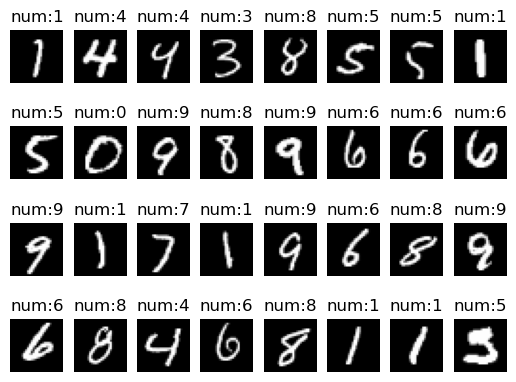

In [97]:
count = 1
for i in images:
    plt.subplot(4, 8, count) 
    plt.imshow(np.squeeze(i), cmap="gray")
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()

通过上述查询操作，看到经过变换后的图片，数据集内分成了1875组数据，每组数据中含有32张图片，每张图片像数值为32×32，数据全部准备好后，就可以进行下一步的数据训练了。

## 定义网络

我们选择相对简单的LeNet网络。LeNet网络不包括输入层的情况下，共有7层：2个卷积层、2个下采样层（池化层）、3个全连接层。每层都包含不同数量的训练参数，如下图所示：

> 更多的LeNet网络的介绍不在此赘述，希望详细了解LeNet网络，可以查询<http://yann.lecun.com/exdb/lenet/>。

在构建LeNet前，我们对全连接层以及卷积层采用Normal进行参数初始化。

MindSpore支持`TruncatedNormal`、`Normal`、`Uniform`等多种参数初始化方法，具体可以参考MindSpore API的`mindspore.common.initializer`模块说明。

使用MindSpore定义神经网络需要继承`mindspore.nn.Cell`，`Cell`是所有神经网络（`Conv2d`等）的基类。

神经网络的各层需要预先在`__init__`方法中定义，然后通过定义`construct`方法来完成神经网络的前向构造，按照LeNet的网络结构，定义网络各层如下：

In [98]:
import mindspore.nn as nn
from mindspore.common.initializer import Normal


class LeNet5(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='pad', padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU() 
        self.avg_pool2d = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        # self.dropout = nn.Dropout(0.5)   # dropout层添加方式

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.avg_pool2d(self.relu(self.conv1(x)))
        x = self.avg_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        #x = self.dropout(x)
        return x

network = LeNet5()
print("layer conv1:", network.conv1)
print("*"*40)
print("layer fc1:", network.fc1)

layer conv1: Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=pad, padding=2, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
****************************************
layer fc1: Dense<input_channels=400, output_channels=120, has_bias=True>


构建完成后，可以使用`print(LeNet5())`将神经网络中的各层参数全部打印出来，也可以使用`LeNet().{layer名称}`打印相应的参数信息。本例选择打印第一个卷积层和第一个全连接层的相应参数。

## 自定义回调函数收集模型的损失值和准确率

自定义一个数据收集的回调类`StepLossAccInfo`，用于收集两类信息：

1. 训练过程中`step`和`loss`值之间关系的信息；
2. 每训练125个`step`和对应模型精度值`accuracy`的信息。

该类继承了`Callback`类，可以自定义训练过程中的操作，等训练完成后，可将数据绘成图查看`step`与`loss`的变化情况，以及`step`与`accuracy`的变化情况。

以下代码会作为回调函数，在模型训练函数`model.train`中调用，本文验证模型阶段会将收集到的信息，进行可视化展示。

In [8]:
from mindspore.train.callback import Callback

# custom callback function
class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps_loss = steps_loss
        self.steps_eval = steps_eval
        
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        cur_step = (cur_epoch-1)*1875 + cb_params.cur_step_num
        self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
        self.steps_loss["step"].append(str(cur_step))
        if cur_step % 125 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])

其中：

- `model`：计算图模型Model。
- `eval_dataset`：验证数据集。
- `steps_loss`：收集step和loss值之间的关系，数据格式`{"step": [], "loss_value": []}`。
- `steps_eval`：收集step对应模型准确率`accuracy`的信息，数据格式为`{"step": [], "acc": []}`。

## 定义损失函数及优化器

在进行定义之前，先简单介绍损失函数及优化器的概念。

- 损失函数：又叫目标函数，用于衡量预测值与实际值差异的程度。深度学习通过不停地迭代来缩小损失函数的值。定义一个好的损失函数，可以有效提高模型的性能。

- 优化器：用于最小化损失函数，从而在训练过程中改进模型。

定义了损失函数后，可以得到损失函数关于权重的梯度。梯度用于指示优化器优化权重的方向，以提高模型性能。

MindSpore支持的损失函数有`SoftmaxCrossEntropyWithLogits`、`L1Loss`、`MSELoss`等。这里使用`SoftmaxCrossEntropyWithLogits`损失函数。

MindSpore支持的优化器有`SGD`、`Adam`、`AdamWeightDecay`、`Momentum`等。这里使用`SGD`优化器。

In [100]:
import mindspore.nn as nn
from mindspore.nn import SoftmaxCrossEntropyWithLogits

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.SGD(network.trainable_params(), learning_rate = 0.01) 
# net_opt = nn.Momentum(network.trainable_params(), 0.01, 0.9)   # 

# define the loss function
# net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_loss = nn.CrossEntropyLoss()

## 训练网络

完成神经网络的构建后，就可以着手进行网络训练了，通过MindSpore提供的`Model.train`接口可以方便地进行网络的训练，参数主要包含：

1. 每个`epoch`需要遍历完成图片的batch数：`epoch_size`；  
2. 训练数据集`ds_train`；  
3. MindSpore提供了callback机制，回调函数`callbacks`，包含`ModelCheckpoint`、`LossMonitor`和`Callback`模型检测参数；其中`ModelCheckpoint`可以保存网络模型和参数，以便进行后续的fine-tuning（微调）操作；    
4. 数据下沉模式`dataset_sink_mode`，此参数默认`True`需设置成`False`，因为此模式不支持CPU计算平台。

In [101]:
import os
from mindspore import Tensor, Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.nn import Accuracy

epoch_size = 1
mnist_path = "./datasets/MNIST_Data"
model_path = "./models/ckpt/mindspore_quick_start/"

repeat_size = 1
ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
eval_dataset = create_dataset(os.path.join(mnist_path, "test"), 32)

# clean up old run files before in Linux
os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))

# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()}) 

# save the network model and parameters for subsequence fine-tuning
config_ck = CheckpointConfig(save_checkpoint_steps=375, keep_checkpoint_max=16)
# group layers into an object with training and evaluation features
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=model_path, config=config_ck) 

steps_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}
# collect the steps,loss and accuracy information
step_loss_acc_info = StepLossAccInfo(model , eval_dataset, steps_loss, steps_eval)


model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(125), step_loss_acc_info], dataset_sink_mode=False)

print("train finished")

[WARNING] ME(30146:140181068878144,MainProcess):2023-02-23-10:15:06.400.877 [mindspore/train/model.py:1079] For StepLossAccInfo callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


epoch: 1 step: 125, loss is 2.2967681884765625
epoch: 1 step: 250, loss is 0.9430797100067139
epoch: 1 step: 375, loss is 0.5607165098190308
epoch: 1 step: 500, loss is 0.26675286889076233
epoch: 1 step: 625, loss is 0.2294234335422516
epoch: 1 step: 750, loss is 0.26451995968818665
epoch: 1 step: 875, loss is 0.27941957116127014
epoch: 1 step: 1000, loss is 0.2920283377170563
epoch: 1 step: 1125, loss is 0.11139946430921555
epoch: 1 step: 1250, loss is 0.04588001221418381
epoch: 1 step: 1375, loss is 0.02639646828174591
epoch: 1 step: 1500, loss is 0.02187664806842804
epoch: 1 step: 1625, loss is 0.29451173543930054
epoch: 1 step: 1750, loss is 0.051440998911857605
epoch: 1 step: 1875, loss is 0.15861104428768158
train finished


运行上述代码输出loss是训练集的loss。训练完成后，会在设置的模型保存路径上生成多个模型文件。

In [102]:
!tree $model_path

./models/ckpt/mindspore_quick_start/
├── checkpoint_lenet-1_1125.ckpt
├── checkpoint_lenet-1_1500.ckpt
├── checkpoint_lenet-1_1875.ckpt
├── checkpoint_lenet-1_375.ckpt
├── checkpoint_lenet-1_750.ckpt
└── checkpoint_lenet-graph.meta

0 directories, 6 files


文件名称具体含义`{ModelCheckpoint中设置的自定义名称}-{第几个epoch}_{第几个step}.ckpt`。

> 使用自由控制循环的迭代次数、遍历数据集等，可以参照官网编程指南《[训练](https://www.mindspore.cn/doc/programming_guide/zh-CN/r1.2/train.html#%E8%87%AA%E5%AE%9A%E4%B9%89%E8%AE%AD%E7%BB%83%E5%BE%AA%E7%8E%AF)》的自定义循环训练部分。


### 查看模型loss和accuracy随着训练步数在测试集上的变化情况

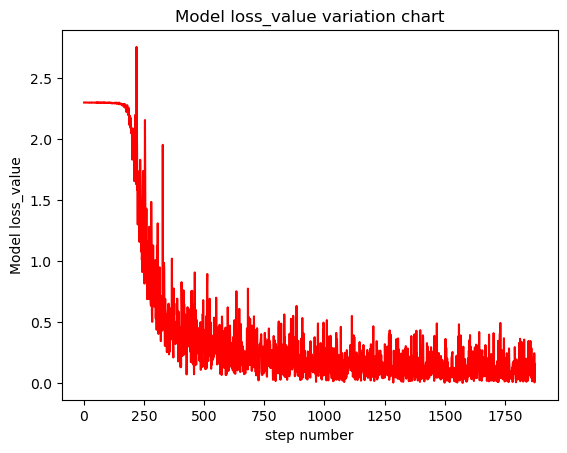

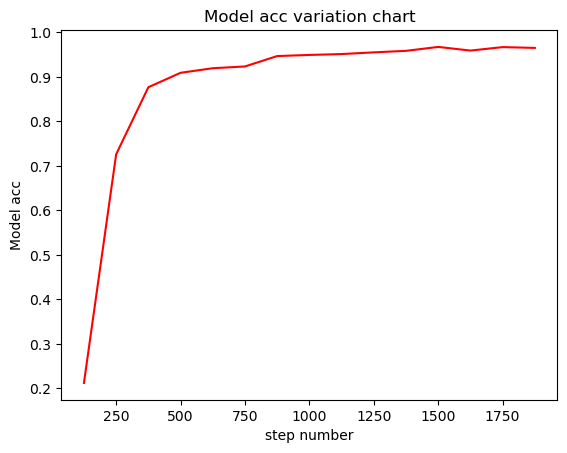

In [103]:
def eval_show(steps_data, metric):
    plt.xlabel("step number")
    plt.ylabel("Model " + metric)
    plt.title("Model " + metric + " variation chart")
    plt.plot(steps_data["step"], steps_data[metric], "red")
    plt.show()

steps = steps_loss["step"]
loss_value = steps_loss["loss_value"]
steps_loss["step"] = list(map(int, steps))
steps_loss["loss_value"] = list(map(float, loss_value))

eval_show(steps_loss, 'loss_value')
eval_show(steps_eval, 'acc')

从上面可以看出来loss变化大致分为三个阶段：

阶段一：训练开始时，loss值在2.2上下浮动。

阶段二：训练到某一时刻，loss值迅速减少，训练收益大幅增加。

阶段三：loss值收敛到一定小的值后，开始振荡在一个小的区间上无法趋0，再继续增加训练并无明显收益，至此训练结束。

loss每个batch都会记录一个值，准确率每125个batch才记录一次，其中`steps_eval`存储着模型的step数和对应模型准确率信息。

从图中可以看出训练得到的模型准确率变化分为三个阶段，跟loss的变化是对应的，但变化趋势相反。

阶段一：训练开始时，模型精度缓慢震荡上升。

阶段二：训练到某一时刻，模型精度迅速上升。

阶段三：缓慢上升趋近于不到1的某个值时附近振荡。

整个训练过程，随着训练数据的增加，会对模型精度有着正相关的影响，但是随着精度到达一定程度，训练收益会降低。

##  验证模型

一般最后保存的模型效果最好，通过在测试数据集评估准确度，验证模型的泛化能力。

验证模型的过程主要为：

1. 载入模型`.ckpt`文件中的参数`param_dict`；
2. 将参数`param_dict`载入到神经网络LeNet中；
3. 载入测试数据集；
4. 调用函数`model.eval`传入参数测试数据集`ds_eval`，生成模型`checkpoint_lenet-{epoch}_1875.ckpt`的精度值。

In [104]:
from mindspore import load_checkpoint, load_param_into_net

# testing relate modules 
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("./models/ckpt/mindspore_quick_start/checkpoint_lenet-1_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    
    # 此处的model是训练之后的，并非是加载param_dict得到的模型
    acc = model.eval(ds_eval, dataset_sink_mode=False)
    print("============== Test data Accuracy:{} ==============".format(acc))

test_net(network, model, mnist_path)

============== Starting Testing ==============
============== Test data Accuracy:{'Accuracy': 0.9649439102564102} ==============


其中：

- `load_checkpoint`：通过该接口加载CheckPoint模型参数文件，返回一个参数字典。

- `checkpoint_lenet-1_1875.ckpt`：之前保存的CheckPoint模型文件名称。

- `load_param_into_net`：通过该接口把参数加载到网络中。

经过1875步训练后生成的模型精度超过95%，模型优良。

我们可以看一下模型随着训练步数变化，精度随之变化的情况。

## 推理预测

我们使用生成的模型应用到分类预测单个或者单组图片数据上，具体步骤如下：

1. 将要测试的数据转换成适应LeNet的数据类型。
2. 提取出`image`的数据。
3. 使用函数`model.predict`预测`image`对应的数字。`predict`返回的是`image`对应0-9的各个可能的值，最大的值是最有可能的分类。
4. 调用`plot`将预测出的各数字显示出来。

载入要预测的数据集，并调用`create_dataset`转换成符合格式要求的数据集，并选取其中一组32张图片进行推理预测。

[10.072937   -3.5322974   2.8743849  -3.31332    -0.30264786 -4.1151676   0.09680806 -2.127269   -0.3714651  -0.72210044]
Row 1, column 5 is incorrectly identified as 4, the correct value should be 9 

[0 3 5 9 4 5 2 4 3 0 0 7 3 2 1 9 8 9 3 4 7 6 1 9 8 6 7 0 2 6 2 6] <--Predicted figures
[0 3 5 9 9 5 2 4 3 0 0 7 3 2 1 9 8 9 3 4 7 6 1 9 8 6 7 0 2 6 2 6] <--The right number


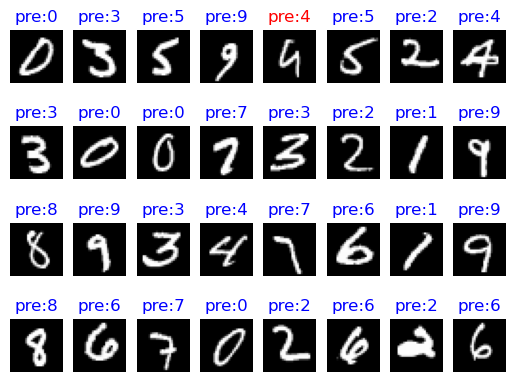

In [105]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

output = model.predict(Tensor(data['image']))
unnorm_result = output[0]  # output[0]模型预测第一个测试图片的结果输出
print(unnorm_result)  
#@TODO，要求unnorm_result中的数据归一化

pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]),cmap="gray")
    plt.axis("off")
    if color == 'red':
        index = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("All the figures in this group are predicted correctly!")
print(pred, "<--Predicted figures") 
print(labels, "<--The right number")
plt.show()

主要参考：https://www.mindspore.cn/tutorial/training/zh-CN/r1.2/quick_start/quick_start.html
本示例用MNIST test数据集进行训练过程的模型验证，有些资料中会通过从训练集中划分一部分出来做验证集，
区别不大，模型训练的主要过程是一致的。